<a href="https://colab.research.google.com/github/mgorsk1/gargabe-detector-app/blob/baseline/classifier_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tensorflow==1.15

In [0]:
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
tf.__version__

'1.15.0'

Link to the data: https://drive.google.com/open?id=1m6-StcbywxvW95NsyibE7tl3PYRdlfcx

copy data to your google drive and modify `project_dir` below. 

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
project_dir = 'drive/My Drive/projects/ING/Experiment_week/garbage_segmentation/'

data_train_dir = project_dir + 'data/raw/train/'
data_test_dir = project_dir + 'data/raw/test/'
models_dir = project_dir + 'models/'

In [7]:
classes = os.listdir(data_train_dir)
classes

['metal', 'paper', 'glass', 'plastic', 'cardboard']

In [8]:
os.listdir(data_test_dir)

['cardboard', 'glass', 'paper', 'plastic', 'metal']

In [0]:
def stack_images_and_labels(data_dir, target_size=(224, 224), do_save=True):
    file_paths = glob.glob(data_dir + '*/*')

    df_files = pd.DataFrame(file_paths, columns=['file_path'])
    df_files = df_files.assign(label=df_files['file_path'].str.split('/').apply(lambda x: x[-2]))

    images_list, labels_list = [], []
    for _, row in tqdm(df_files.iterrows(), total=len(df_files)):
        file_path = row[0]
        label = row[1]

        image = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)
        image = tf.keras.preprocessing.image.img_to_array(image)

        images_list.append(image)
        labels_list.append(label)

    images = np.stack(images_list)
    labels = np.stack(labels_list)

    if do_save:
        np.save(data_dir.replace('raw', 'processed') + f'images_{target_size[0]}.npy', images)
        np.save(data_dir.replace('raw', 'processed') + 'labels.npy', labels)

    return images, labels

In [9]:
images_train, labels_train = stack_images_and_labels(data_train_dir)

In [13]:
images_test, labels_test = stack_images_and_labels(data_test_dir)

In [10]:
images_train = np.load(data_train_dir.replace('raw', 'processed') + 'images_224.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')
images_test = np.load(data_test_dir.replace('raw', 'processed') + 'images_224.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_train.shape, labels_train.shape, images_test.shape, labels_test.shape

((3989, 224, 224, 3), (3989,), (186, 224, 224, 3), (186,))

In [0]:
def plot_images(images, labels, label_to_plot=None):
    images = np.copy(images)
    labels = np.copy(labels)

    if label_to_plot:
        indices = [i for i, label in enumerate(labels) if label == label_to_plot]
        images = images[indices]
        labels = labels[indices]

    indices = np.random.choice(range(len(images)), size=10)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = [j for i in axs for j in i]
    for i, index in enumerate(indices):
        axs[i].imshow(images[index].astype(int)) 
        axs[i].set_title(labels[index])

    plt.tight_layout()

In [0]:
label_to_plot = None

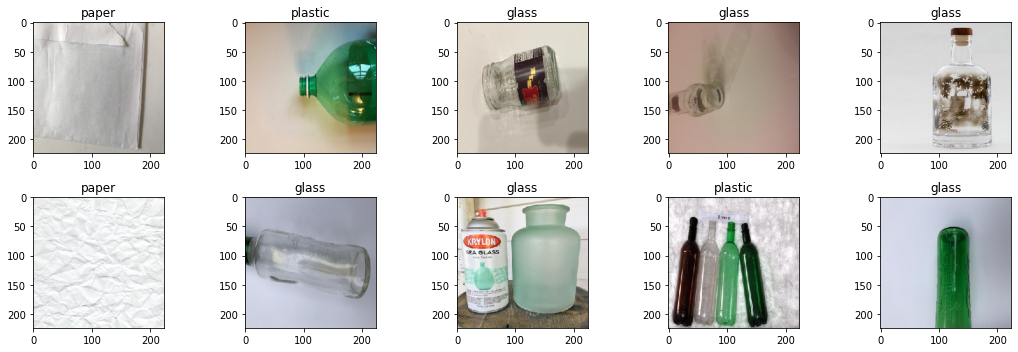

In [12]:
plot_images(images_train, labels_train, label_to_plot)

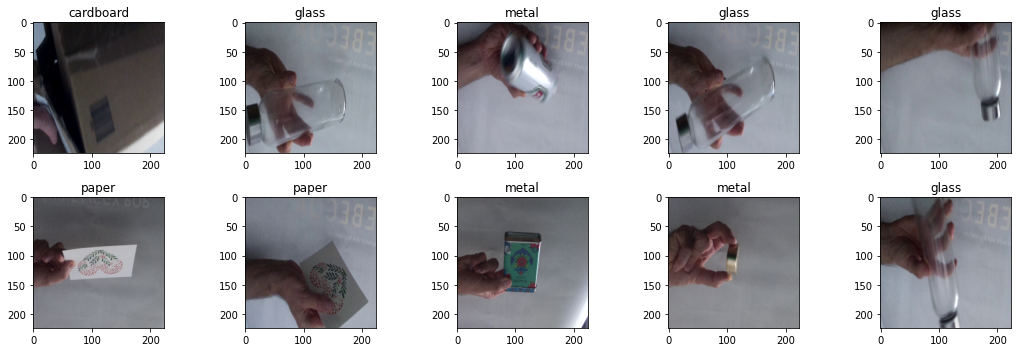

In [13]:
plot_images(images_test, labels_test, label_to_plot)

In [0]:
def to_categorical(labels, label_to_index):
    labels_int = pd.Series(labels).map(label_to_index)
    return tf.keras.utils.to_categorical(labels_int, num_classes=len(label_to_index)) 

In [0]:
label_to_index = dict(zip(classes, range(len(classes))))

labels_train_c = to_categorical(labels_train, label_to_index)
labels_test_c = to_categorical(labels_test, label_to_index)

In [17]:
images_train, images_val, labels_train_c, labels_val_c = train_test_split(images_train, labels_train_c, random_state=1)
images_train.shape

(2991, 224, 224, 3)

Text(0.5, 1.0, 'glass')

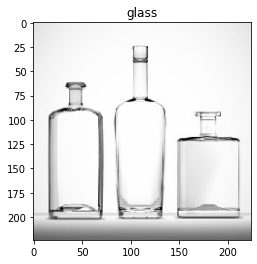

In [17]:
idx = 2

plt.imshow(images_train[idx].astype(int))
plt.title(classes[labels_train_c.argmax(axis=1)[idx]])

In [19]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
model_base = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
images_train = preprocess_input(images_train)
images_val = preprocess_input(images_val)
images_test = preprocess_input(images_test)

In [0]:
def make_model(model_base):
    for layer in model_base.layers:
        layer.trainable = False

    x = tf.keras.layers.Flatten()(model_base.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    return tf.keras.models.Model(inputs=model_base.input, outputs=output)

In [0]:
model = make_model(model_base)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

In [29]:
new_learning_rate = 0.001

print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))
tf.keras.backend.set_value(model.optimizer.lr, new_learning_rate)
print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))

current_learning_rate 1e-04
current_learning_rate 0.001


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180, 
    width_shift_range=0.4,
    height_shift_range=0.4, 
    # brightness_range=[0.2, 1.0], 
    # shear_range=0.2, 
    # zoom_range=0.2,
    fill_mode='nearest', 
    horizontal_flip=True,
    vertical_flip=True
)

In [0]:
datagen.fit(images_train)

In [31]:
model.fit(
    datagen.flow(images_train, labels_train_c, batch_size=32),
    steps_per_epoch=len(images_train)//32, 
    validation_data=(images_val, labels_val_c),
    validation_freq=2,
    epochs=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(models_dir + 'model.h5', monitor='val_loss', save_best_only=True)]
)

Epoch 1/100
93/93 [==============================] - 29s 316ms/step - loss: 0.5120
Epoch 2/100
93/93 [==============================] - 49s 523ms/step - loss: 0.5527 - val_loss: 0.6546
Epoch 3/100
93/93 [==============================] - 29s 313ms/step - loss: 0.5596
Epoch 4/100
93/93 [==============================] - 38s 409ms/step - loss: 0.5427 - val_loss: 0.5113
Epoch 5/100
93/93 [==============================] - 29s 308ms/step - loss: 0.5108
Epoch 6/100
93/93 [==============================] - 31s 337ms/step - loss: 0.5318 - val_loss: 0.5769
Epoch 7/100
93/93 [==============================] - 28s 301ms/step - loss: 0.5555
Epoch 8/100
93/93 [==============================] - 31s 338ms/step - loss: 0.5313 - val_loss: 0.5558
Epoch 9/100
93/93 [==============================] - 28s 299ms/step - loss: 0.4972
Epoch 10/100
93/93 [==============================] - 32s 342ms/step - loss: 0.4889 - val_loss: 0.6402
Epoch 11/100
93/93 [==============================] - 28s 299ms/step - los

In [11]:
model = tf.keras.models.load_model(models_dir + 'model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [91]:
prediction_train = model.predict(images_train)

print(
    classification_report(
        labels_train_c.argmax(axis=1), 
        prediction_train.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.96      0.85      0.90       630
       paper       0.92      0.98      0.95       629
       glass       0.94      0.84      0.89       730
     plastic       0.80      0.96      0.87       698
   cardboard       0.99      0.91      0.95       304

    accuracy                           0.90      2991
   macro avg       0.92      0.91      0.91      2991
weighted avg       0.91      0.90      0.91      2991



In [21]:
prediction_val = model.predict(images_val)

print(
    classification_report(
        labels_val_c.argmax(axis=1), 
        prediction_val.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.94      0.82      0.87       216
       paper       0.88      0.98      0.92       224
       glass       0.91      0.78      0.84       223
     plastic       0.80      0.92      0.85       236
   cardboard       0.96      0.90      0.93        99

    accuracy                           0.88       998
   macro avg       0.89      0.88      0.88       998
weighted avg       0.88      0.88      0.88       998



In [22]:
prediction_test = model.predict(images_test)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.71      0.10      0.18        50
       paper       0.33      0.94      0.49        36
       glass       0.53      0.36      0.43        45
     plastic       0.26      0.36      0.30        25
   cardboard       0.90      0.30      0.45        30

    accuracy                           0.39       186
   macro avg       0.55      0.41      0.37       186
weighted avg       0.56      0.39      0.36       186



In [32]:
model.save(models_dir + 'model.h5')
tf.saved_model.save(model, models_dir + "saved_model/")

INFO:tensorflow:Assets written to: drive/My Drive/projects/ING/Experiment_week/garbage_segmentation/models/saved_model/assets


In [0]:
images_test_all = np.load(data_test_dir.replace('raw', 'processed') + 'images_224.npy')

wrong_images = images_test_all[prediction_test.argmax(axis=1) != labels_test_c.argmax(axis=1)]
wrong_labels = prediction_test[prediction_test.argmax(axis=1) != labels_test_c.argmax(axis=1)]

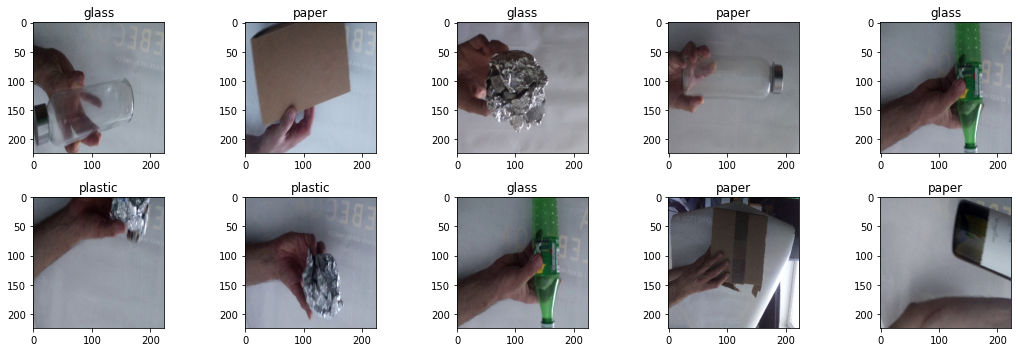

In [26]:
plot_images(wrong_images, [classes[l] for l in prediction_test.argmax(axis=1)])

In [105]:
(wrong_images*127.5).min(), wrong_images.max()

(-123.68, 151.061)